In [1]:
import numpy as np 
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold
import sklearn.model_selection as skl_model
from sklearn.preprocessing import OneHotEncoder
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

## 1. Linear Regression using a simple perceptron 

### For  getting  into  graduate  school,  download  the grad school attribute data set from Files.  

#### a) Define the features that are related to predicting the Chance of Admit, and normalize them. 

In [2]:
df = pd.read_csv("Admission_Predict_Ver1.1.csv")
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [3]:
# drop the serial number
df = df.drop("Serial No.", axis=1)
chance = df["Chance of Admit "]
df = df.drop("Chance of Admit ", axis=1)
#normalize the rest of the data 
df = (df - df.mean()) / df.std()
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,1.817417,1.777086,0.774806,1.136222,1.097845,1.775029,0.885518
1,0.666481,-0.031569,0.774806,0.631683,1.097845,0.485373,0.885518
2,-0.041788,-0.524839,-0.099693,-0.377395,0.017289,-0.953088,0.885518
3,0.489414,0.461700,-0.099693,0.127144,-1.063267,0.154692,0.885518
4,-0.218855,-0.689262,-0.974192,-1.386473,-0.522989,-0.605873,-1.127023


####  b) Fill in the code for a simple perceptron. Initialize your weights and biases between 0 and 0.05 using your random number generator. Use the mean squares error (MSE) to adjust your weights through back-propagation. Fill in the blanks for the feedforward and backpropagation step.

In [2]:
class simple_perceptron():
    def __init__(self,input_dim,output_dim,learning_rate=0.01,activation=lambda x:x,activation_grad=lambda x:1):
        
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.activation=activation
        self.activation_grad=activation_grad
        self.lr=learning_rate
        ### initialize weights between 0 and 0.05 ###
        self.weights=np.random.rand(input_dim,output_dim)*0.05
        self.biases=np.random.rand(1,output_dim)*0.05
        
    def predict(self,X):
        if len(X.shape)==1:
            X=X.reshape((-1,1))
        dim=X.shape[1]
        # Check that the dimension of accepted input data is the same as expected
        if not dim==self.input_dim:
            raise Exception("Expected input size %d, accepted %d!"%(self.input_dim,dim))
        ### Calculate logit and activation ### 
        self.z=X.dot(self.weights)+self.biases
        self.a=self.activation(self.z)
        return self.a
    
    def fit(self,X,y):
        # Transform the single-sample data into 2-dimensional, for the convenience of matrix multiplication
        if len(X.shape)==1:
            X=X.reshape((-1,1))
        if len(y.shape)==1:
            y=y.reshape((-1,1))
        self.predict(X)
        errors=(self.a-y)*self.activation_grad(self.z)
        weights_grad=errors.T.dot(X)
        bias_grad=np.sum(errors,axis=0)
        ### Update weights and biases from the gradient ###
        self.weights -= weights_grad.T*self.lr
        self.biases -= bias_grad*self.lr
        
    def train_on_epoch(self,X,y,batch_size=32):
        # Every time select batch_size samples from the training set, until all data in the training set has been trained once
        order=list(range(X.shape[0]))
        random.shuffle(order)
        n=0
        while n<math.ceil(len(order)/batch_size)-1: # Parts that can fill one batch
            self.fit(X[order[n*batch_size:(n+1)*batch_size]],y[order[n*batch_size:(n+1)*batch_size]])
            n+=1
        # Parts that cannot fill one batch
        self.fit(X[order[n*batch_size:]],y[order[n*batch_size:]])
        
    def evaluate(self,X,y):
         # Transform the single-sample data into 2-dimensional
        if len(X.shape)==1:
            X=X.reshape((1,-1))
        if len(y.shape)==1:
            y=y.reshape((1,-1))
        ### means square error ###
        return np.mean((self.predict(X)-y)**2)
    
    def get_weights(self):
        return (self.weights,self.biases)
    
    def set_weights(self,weights):
        self.weights=weights[0]
        self.biases=weights[1]

#### c) Fill in the code for k-fold validation. Use 80% of the data for training and 20% of the data for testing and do 5-fold validation. Use a learning rate of 0.0001. Are the features good indicators for getting into graduate school? Now remove the GRE scores and do the same test; are GRE scores important?

In [3]:
def Kfold(k,Xs,ys,epochs,learning_rate=0.0001,draw_curve=False):
    # The total number of examples for training the network
    total_num=len(Xs)
    
    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    # record error for each model
    train_error_all=[]
    test_error_all=[]
    
    for train_selector,test_selector in kf.split(range(total_num)):
        ### Decide training examples and testing examples for this fold ###
        train_Xs=Xs[train_selector]
        test_Xs=Xs[test_selector]
        train_ys=ys[train_selector]
        test_ys=ys[test_selector]

    val_array=[]
    # Split training examples further into training and validation
    train_in,val_in,train_real,val_real=train_test_split(train_Xs,train_ys)
        
    ### Establish the model for simple perceptron here ###
    model=simple_perceptron(Xs.shape[1], 1, learning_rate=learning_rate)
        
    # Save the lowest weights, so that we can recover the best model
    weights = model.get_weights()
    lowest_val_err = np.inf
    for _ in range(epochs):
        # Train model on a number of epochs, and test performance in the validation set
        model.train_on_epoch(train_in,train_real)
        val_err = model.evaluate(val_in,val_real)
        val_array.append(val_err)
        if val_err < lowest_val_err:
            lowest_val_err = val_err
            weights = model.get_weights()
        # The final number of epochs is when the minimum error in validation set occurs    
        final_epochs=np.argmin(val_array)+1
        print("Number of epochs with lowest validation:",final_epochs)
        # Recover the model weight
        model.set_weights(weights)

        # Report result for this fold
        train_error=model.evaluate(train_Xs,train_ys)
        train_error_all.append(train_error)
        test_error=model.evaluate(test_Xs,test_ys)
        test_error_all.append(test_error)
        print("Train error:",train_error)
        print("Test error:",test_error)
        
        if draw_curve:
            plt.figure()
            plt.plot(np.arange(len(val_array))+1,val_array,label='Validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            
    print("Final results:")
    print("Training error:%f+-%f"%(np.average(train_error_all),np.std(train_error_all)))
    print("Testing error:%f+-%f"%(np.average(test_error_all),np.std(test_error_all)))
    
    # return the last model
    return model

In [4]:
def show_correlation(xs,ys):
    plt.figure()
    plt.scatter(xs,ys,s=0.5)
    r = [np.min([np.min(xs),np.min(ys)]),np.max([np.max(xs),np.max(ys)])]
    plt.plot(r,r,'r')
    plt.xlabel("Predictions")
    plt.ylabel("Ground truth")
    corr=np.corrcoef([xs,ys])[1,0]
    print("Correlation coefficient:",corr)

#### Testing the code above. Please note that I have assigned False to draw curve because my jupyter notebook kept crashing

In [7]:
import sklearn.model_selection as skl_model
Xs = df.to_numpy() 
ys = chance.to_numpy()

train_feat,test_feat,train_ranking,test_ranking=skl_model.train_test_split(Xs, ys, test_size = 0.20)
res = Kfold(k=5, Xs=train_feat, ys=train_ranking, epochs=1000)

Number of epochs with lowest validation: 1
Train error: 0.5270166307157261
Test error: 0.5337397908318257
Number of epochs with lowest validation: 2
Train error: 0.5047387640916025
Test error: 0.5121574461255333
Number of epochs with lowest validation: 3
Train error: 0.4834924120397273
Test error: 0.4915065622835508
Number of epochs with lowest validation: 4
Train error: 0.4631898958349122
Test error: 0.4716883119145267
Number of epochs with lowest validation: 5
Train error: 0.4438544380434648
Test error: 0.4527853553026307
Number of epochs with lowest validation: 6
Train error: 0.42537611345076093
Test error: 0.4346460851098549
Number of epochs with lowest validation: 7
Train error: 0.407740557351851
Test error: 0.41728675757107697
Number of epochs with lowest validation: 8
Train error: 0.3908987167169507
Test error: 0.40066304664218777
Number of epochs with lowest validation: 9
Train error: 0.37475708514326106
Test error: 0.3846458055901454
Number of epochs with lowest validation: 10

Train error: 0.03788776502505589
Test error: 0.041760238329480795
Number of epochs with lowest validation: 141
Train error: 0.03784757011781972
Test error: 0.04171111313668706
Number of epochs with lowest validation: 142
Train error: 0.03780322696049568
Test error: 0.04165702622742895
Number of epochs with lowest validation: 143
Train error: 0.037762026006772614
Test error: 0.04160651448404005
Number of epochs with lowest validation: 144
Train error: 0.03772440717733437
Test error: 0.04156011048469736
Number of epochs with lowest validation: 145
Train error: 0.037696716942380075
Test error: 0.04152517387904731
Number of epochs with lowest validation: 146
Train error: 0.03766503104832752
Test error: 0.04148553030071666
Number of epochs with lowest validation: 147
Train error: 0.03763199276752768
Test error: 0.041444228742321426
Number of epochs with lowest validation: 148
Train error: 0.03759595963329022
Test error: 0.0413993720656157
Number of epochs with lowest validation: 149
Train e

Train error: 0.03677837735737632
Test error: 0.04011100434162747
Number of epochs with lowest validation: 261
Train error: 0.03677945422791172
Test error: 0.040109942313915
Number of epochs with lowest validation: 261
Train error: 0.03678264963473188
Test error: 0.04011130118889733
Number of epochs with lowest validation: 261
Train error: 0.03677835010229316
Test error: 0.040104111180771354
Number of epochs with lowest validation: 266
Train error: 0.03677689715144786
Test error: 0.04010021507818545
Number of epochs with lowest validation: 267
Train error: 0.03677416641259647
Test error: 0.04009488075318805
Number of epochs with lowest validation: 268
Train error: 0.03677298549218916
Test error: 0.040091313262972925
Number of epochs with lowest validation: 268
Train error: 0.03677594801622985
Test error: 0.04009243896197584
Number of epochs with lowest validation: 270
Train error: 0.036773114415476565
Test error: 0.040087021331342995
Number of epochs with lowest validation: 270
Train er

Train error: 0.036783062773625266
Test error: 0.039892964667970536
Number of epochs with lowest validation: 390
Train error: 0.036782068636900964
Test error: 0.03989073111125736
Number of epochs with lowest validation: 390
Train error: 0.036784782957449656
Test error: 0.03989268882376893
Number of epochs with lowest validation: 390
Train error: 0.03678502262892184
Test error: 0.03989186786511181
Number of epochs with lowest validation: 390
Train error: 0.03678121921579527
Test error: 0.03988646632758594
Number of epochs with lowest validation: 390
Train error: 0.03677775068652756
Test error: 0.0398814772594737
Number of epochs with lowest validation: 403
Train error: 0.036775531757674715
Test error: 0.03987789736067361
Number of epochs with lowest validation: 403
Train error: 0.036781492659997354
Test error: 0.03988353439679107
Number of epochs with lowest validation: 403
Train error: 0.0367847990729513
Test error: 0.039886157268791314
Number of epochs with lowest validation: 403
Train

Train error: 0.036817269293147395
Test error: 0.03982094223829195
Number of epochs with lowest validation: 505
Train error: 0.036819623897814596
Test error: 0.03982310301735252
Number of epochs with lowest validation: 505
Train error: 0.036817035770136855
Test error: 0.039819685213355396
Number of epochs with lowest validation: 505
Train error: 0.036821729950486624
Test error: 0.03982446546950966
Number of epochs with lowest validation: 505
Train error: 0.03682235560482397
Test error: 0.039824608510412134
Number of epochs with lowest validation: 505
Train error: 0.036822301652457395
Test error: 0.03982400265972862
Number of epochs with lowest validation: 505
Train error: 0.036824315634508165
Test error: 0.039825740746553324
Number of epochs with lowest validation: 505
Train error: 0.0368277900017875
Test error: 0.0398290924237957
Number of epochs with lowest validation: 505
Train error: 0.03682773392382097
Test error: 0.0398285159127866
Number of epochs with lowest validation: 505
Trai

Number of epochs with lowest validation: 608
Train error: 0.036859119114399326
Test error: 0.039822858671596094
Number of epochs with lowest validation: 608
Train error: 0.03685411344663138
Test error: 0.03981695157307831
Number of epochs with lowest validation: 608
Train error: 0.03685862679768508
Test error: 0.03982171181550433
Number of epochs with lowest validation: 608
Train error: 0.036860412452010986
Test error: 0.03982340699594614
Number of epochs with lowest validation: 608
Train error: 0.036855874259758656
Test error: 0.03981801701776078
Number of epochs with lowest validation: 608
Train error: 0.036858947699997494
Test error: 0.03982120774105706
Number of epochs with lowest validation: 608
Train error: 0.036861725198535734
Test error: 0.039823977336151305
Number of epochs with lowest validation: 608
Train error: 0.03686164420593627
Test error: 0.03982361280282341
Number of epochs with lowest validation: 608
Train error: 0.036865120426366346
Test error: 0.039827259440531844
N

Train error: 0.036882652328192454
Test error: 0.03982078247576056
Number of epochs with lowest validation: 608
Train error: 0.03688219101895815
Test error: 0.039820134112187586
Number of epochs with lowest validation: 608
Train error: 0.0368759093232553
Test error: 0.03981301725414182
Number of epochs with lowest validation: 608
Train error: 0.0368747990314663
Test error: 0.03981162246096399
Number of epochs with lowest validation: 608
Train error: 0.03687385778396861
Test error: 0.039810436137520305
Number of epochs with lowest validation: 608
Train error: 0.03687579242421519
Test error: 0.039812441142920874
Number of epochs with lowest validation: 608
Train error: 0.03687713602456399
Test error: 0.03981378587651694
Number of epochs with lowest validation: 608
Train error: 0.03687998517629043
Test error: 0.03981684884596276
Number of epochs with lowest validation: 608
Train error: 0.03687927336222319
Test error: 0.03981590179117579
Number of epochs with lowest validation: 608
Train er

Train error: 0.03689418801177271
Test error: 0.03981634019901147
Number of epochs with lowest validation: 608
Train error: 0.036901970790070765
Test error: 0.039825017219330155
Number of epochs with lowest validation: 608
Train error: 0.036894801378426385
Test error: 0.03981692889156358
Number of epochs with lowest validation: 608
Train error: 0.03689721022760205
Test error: 0.039819600310220644
Number of epochs with lowest validation: 608
Train error: 0.03689860957986047
Test error: 0.03982111471500753
Number of epochs with lowest validation: 608
Train error: 0.03689534101457652
Test error: 0.039817398072708475
Number of epochs with lowest validation: 608
Train error: 0.03689606047709582
Test error: 0.03981816580415139
Number of epochs with lowest validation: 608
Train error: 0.03689472696347205
Test error: 0.03981663392644526
Number of epochs with lowest validation: 608
Train error: 0.03689298242693998
Test error: 0.03981465052852446
Number of epochs with lowest validation: 608
Train

<IPython.core.display.Javascript object>


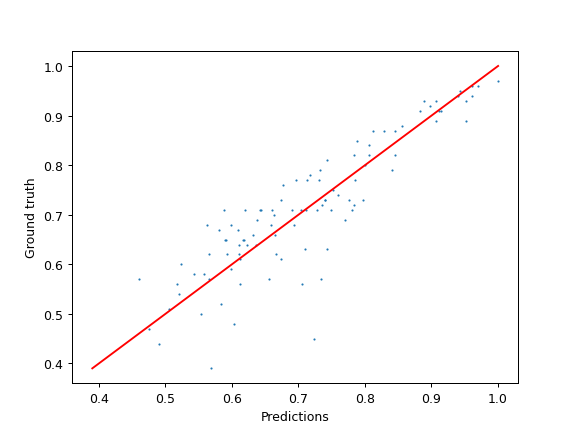

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 100) + inhomogeneous part.

In [16]:
prediction = res.predict(test_feat)
test_ranking.reshape(100,1)
show_correlation(prediction, test_ranking)

#### Removing GRE scores and then testing the above code 

In [8]:
df = df.drop("GRE Score", axis=1)
Xs = df.to_numpy() 
ys = chance.to_numpy()

train_feat,test_feat,train_ranking,test_ranking=skl_model.train_test_split(Xs, ys, test_size = 0.20)
res = Kfold(k=5, Xs=train_feat, ys=train_ranking, epochs=1000)

Number of epochs with lowest validation: 1
Train error: 0.4835221771125241
Test error: 0.4525505259145335
Number of epochs with lowest validation: 2
Train error: 0.46255539257106704
Test error: 0.4325639090444405
Number of epochs with lowest validation: 3
Train error: 0.4425653730033964
Test error: 0.4135058189987795
Number of epochs with lowest validation: 4
Train error: 0.42349908959467614
Test error: 0.3953250499390189
Number of epochs with lowest validation: 5
Train error: 0.40537540927575777
Test error: 0.3780518204551172
Number of epochs with lowest validation: 6
Train error: 0.38806979064720487
Test error: 0.36155138271663245
Number of epochs with lowest validation: 7
Train error: 0.37158808006011257
Test error: 0.3458385421589899
Number of epochs with lowest validation: 8
Train error: 0.3558910081406623
Test error: 0.3308778119105942
Number of epochs with lowest validation: 9
Train error: 0.34090384060236795
Test error: 0.3165904722005156
Number of epochs with lowest validation

Train error: 0.038938792924605045
Test error: 0.033786675530240076
Number of epochs with lowest validation: 122
Train error: 0.03887667620885575
Test error: 0.03375439128252488
Number of epochs with lowest validation: 123
Train error: 0.038816731292524005
Test error: 0.03372381380510896
Number of epochs with lowest validation: 124
Train error: 0.03875895636433746
Test error: 0.03369492011963843
Number of epochs with lowest validation: 125
Train error: 0.038704078401373215
Test error: 0.033668385554511265
Number of epochs with lowest validation: 126
Train error: 0.03864989422698832
Test error: 0.033642251851990754
Number of epochs with lowest validation: 127
Train error: 0.03860930302036817
Test error: 0.03362742251168358
Number of epochs with lowest validation: 128
Train error: 0.03855865462089438
Test error: 0.03360395480959421
Number of epochs with lowest validation: 129
Train error: 0.038515489706807744
Test error: 0.0335865954981124
Number of epochs with lowest validation: 130
Trai

Number of epochs with lowest validation: 198
Train error: 0.03777257252681281
Test error: 0.03409724843361893
Number of epochs with lowest validation: 198
Train error: 0.037777544086875746
Test error: 0.03410375690680939
Number of epochs with lowest validation: 198
Train error: 0.03778281630380294
Test error: 0.034110491781983276
Number of epochs with lowest validation: 198
Train error: 0.037787305222967624
Test error: 0.03411651585143969
Number of epochs with lowest validation: 198
Train error: 0.03778848721193901
Test error: 0.03411979843046999
Number of epochs with lowest validation: 198
Train error: 0.037793079836446114
Test error: 0.03412587319668879
Number of epochs with lowest validation: 198
Train error: 0.03780003620708763
Test error: 0.034133878554496254
Number of epochs with lowest validation: 198
Train error: 0.03780292954048157
Test error: 0.03413850737038144
Number of epochs with lowest validation: 198
Train error: 0.037804390034033714
Test error: 0.03414190365317423
Numb

Number of epochs with lowest validation: 198
Train error: 0.03794005584255375
Test error: 0.03442106174961394
Number of epochs with lowest validation: 198
Train error: 0.03793967099851939
Test error: 0.03442123314042731
Number of epochs with lowest validation: 198
Train error: 0.03794112839592105
Test error: 0.03442289864406169
Number of epochs with lowest validation: 198
Train error: 0.03794175104300549
Test error: 0.03442382766749133
Number of epochs with lowest validation: 198
Train error: 0.03794396174981214
Test error: 0.03442610384502753
Number of epochs with lowest validation: 198
Train error: 0.037943758775764364
Test error: 0.03442639737315657
Number of epochs with lowest validation: 198
Train error: 0.03794217237929964
Test error: 0.03442557591081184
Number of epochs with lowest validation: 198
Train error: 0.037944725509685
Test error: 0.034428118600219174
Number of epochs with lowest validation: 198
Train error: 0.03794491644180836
Test error: 0.0344287008887991
Number of e

Train error: 0.03798473130908208
Test error: 0.03449508353820863
Number of epochs with lowest validation: 198
Train error: 0.037985595192964315
Test error: 0.03449605688927575
Number of epochs with lowest validation: 198
Train error: 0.03798339617926138
Test error: 0.034494473964945864
Number of epochs with lowest validation: 198
Train error: 0.037984870506371345
Test error: 0.03449594036112189
Number of epochs with lowest validation: 198
Train error: 0.03798811154951777
Test error: 0.0344988736045818
Number of epochs with lowest validation: 198
Train error: 0.03799222902205856
Test error: 0.03450252669111387
Number of epochs with lowest validation: 198
Train error: 0.03798960588735893
Test error: 0.03450062793647911
Number of epochs with lowest validation: 198
Train error: 0.03799267861771414
Test error: 0.03450335235939889
Number of epochs with lowest validation: 198
Train error: 0.037989253685085704
Test error: 0.034500807412145125
Number of epochs with lowest validation: 198
Train 

Number of epochs with lowest validation: 198
Train error: 0.03801191416662724
Test error: 0.03453721506186944
Number of epochs with lowest validation: 198
Train error: 0.03801156077312763
Test error: 0.034537068300795615
Number of epochs with lowest validation: 198
Train error: 0.038009783043120166
Test error: 0.03453570346753561
Number of epochs with lowest validation: 198
Train error: 0.03801204865593635
Test error: 0.03453769741629968
Number of epochs with lowest validation: 198
Train error: 0.03801326598607331
Test error: 0.03453882676843266
Number of epochs with lowest validation: 198
Train error: 0.03801330924332531
Test error: 0.03453902898208512
Number of epochs with lowest validation: 198
Train error: 0.038016128403134654
Test error: 0.03454149352345509
Number of epochs with lowest validation: 198
Train error: 0.03802088254276267
Test error: 0.03454552099281001
Number of epochs with lowest validation: 198
Train error: 0.038022127971198035
Test error: 0.03454667377282079
Number

Number of epochs with lowest validation: 198
Train error: 0.03802750441530325
Test error: 0.034565975635806254
Number of epochs with lowest validation: 198
Train error: 0.03802715890520695
Test error: 0.03456574761352359
Number of epochs with lowest validation: 198
Train error: 0.038022009834698146
Test error: 0.03456157150758358
Number of epochs with lowest validation: 198
Train error: 0.03802320615087479
Test error: 0.03456254650111572
Number of epochs with lowest validation: 198
Train error: 0.038019694317071896
Test error: 0.03455973120495381
Number of epochs with lowest validation: 198
Train error: 0.03802332414046048
Test error: 0.03456272164837831
Number of epochs with lowest validation: 198
Train error: 0.0380212759407774
Test error: 0.034561107231978125
Number of epochs with lowest validation: 198
Train error: 0.03802043789823299
Test error: 0.03456051025763811
Number of epochs with lowest validation: 198
Train error: 0.038020750782153924
Test error: 0.03456082381962365
Number

Number of epochs with lowest validation: 198
Train error: 0.03802293662659597
Test error: 0.03456801915690489
Number of epochs with lowest validation: 198
Train error: 0.03802206832847692
Test error: 0.03456738812017012
Number of epochs with lowest validation: 198
Train error: 0.03802490755072545
Test error: 0.034569763677092656
Number of epochs with lowest validation: 198
Train error: 0.03802916757668482
Test error: 0.03457329699366623
Number of epochs with lowest validation: 198
Train error: 0.038028848206695456
Test error: 0.03457307780162258
Number of epochs with lowest validation: 198
Train error: 0.0380265802649161
Test error: 0.03457121360929822
Number of epochs with lowest validation: 198
Train error: 0.03802336525910101
Test error: 0.03456861242847488
Number of epochs with lowest validation: 198
Train error: 0.03802446351362123
Test error: 0.034569584956161775
Number of epochs with lowest validation: 198
Train error: 0.03802724108070836
Test error: 0.034571885106819154
Number 

<IPython.core.display.Javascript object>


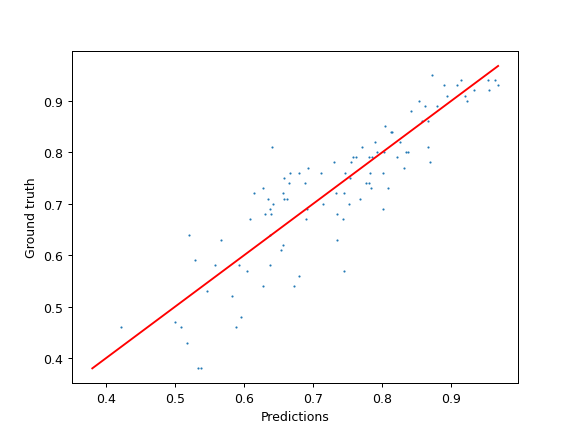

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 100) + inhomogeneous part.

In [9]:
prediction = res.predict(test_feat)
show_correlation(prediction, test_ranking)

#### Looking at the two graphs provided above, it is clear that removing GRE from the list of features does not affect how accurate the predicition is for the chance of admission. This implies that the weights associated with these features are not large enough to affect the true prediction. Thus, it can be assumed that GRE is not an important feature that needs to be taken into account to determine the chance of admission

## 2.Logistic regression using a simple perceptron.

### For whether your status is sufficient to make it off the Titanic, download the Titanic data set from Files.

#### a) Process the dataset. What changes from problem 1? Filter out data with missing features. Use one hot encoders to transform the categorical features and the output survival status. 


#### In this data set, there are some missing features, as noted in the question. Additionally, there are categorical values which were not present in the previous question. I removed some of the features such as the name, ticket, cabin, and passenger id information, which should ideally not affected the prediction in the first place. 

In [5]:
### Read in the titanic dataset ###
titanic=pd.read_csv('titantic.csv')
### Filter out data with missing values 
titanic=titanic.dropna()
### remove name, ticket, cabin, and passenger id
titanic=titanic.drop(['Name','Ticket','Cabin','PassengerId'],axis=1)
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1,1,1,female,38.0,1,0,71.2833,C
3,1,1,female,35.0,1,0,53.1000,S
6,0,1,male,54.0,0,0,51.8625,S
10,1,3,female,4.0,1,1,16.7000,S
11,1,1,female,58.0,0,0,26.5500,S


In [7]:
## Encode the categorical data Pclass, sex, sibSp, parch, embarked
categorical_feats = titanic[['Pclass','Sex', 'SibSp', 'Parch', 'Embarked']]
continuous_feats = titanic[['Age', 'Fare']]
encoder = OneHotEncoder() 
encoder.fit(categorical_feats)
categorical_feats = encoder.transform(categorical_feats).toarray()

survived = np.array(titanic['Survived']).reshape(-1,1)
res_encoder = OneHotEncoder()
survived = res_encoder.fit_transform(survived)
survived = res_encoder.inverse_transform(survived)

### Stack together 
feats = np.hstack((continuous_feats, categorical_feats)) #[  ] [] = [   ]

####  b) Use the simple perceptome model we developed in Q1. Use 80% of the data for training and 20% of the data for testing and do 5-fold validation. Can we predict who will survive? Play around with the features to determine which ones give you a better chance to get back to shore.

In [8]:
train_feat,test_feat,train_ranking,test_ranking=skl_model.train_test_split(feats, survived, test_size = 0.20)
res = Kfold(k=5, Xs=train_feat, ys=train_ranking, epochs=1000)

Number of epochs with lowest validation: 1
Train error: 1968963312.7293162
Test error: 4842265080.853708
Number of epochs with lowest validation: 1
Train error: 1.1096850061660707e+18
Test error: 2.8029873262498493e+18
Number of epochs with lowest validation: 1
Train error: 6.881139634228464e+26
Test error: 1.704584991688784e+27
Number of epochs with lowest validation: 1
Train error: 2.634122777695826e+35
Test error: 6.292137470711364e+35
Number of epochs with lowest validation: 1
Train error: 1.4088214495025131e+44
Test error: 3.546870705348449e+44
Number of epochs with lowest validation: 1
Train error: 7.990280132824655e+52
Test error: 2.005205843457238e+53
Number of epochs with lowest validation: 1
Train error: 4.8384619766974766e+61
Test error: 1.2108239163823889e+62
Number of epochs with lowest validation: 1
Train error: 2.6891824117298846e+70
Test error: 6.671805366123109e+70
Number of epochs with lowest validation: 1
Train error: 1.5966097728893264e+79
Test error: 4.059460538304

/home/jeffy011/CHEM277B/msse/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_18350/1268145792.py:57: RuntimeWarning: overflow encountered in square
  return np.mean((self.predict(X)-y)**2)
/tmp/ipykernel_18350/1268145792.py:36: RuntimeWarning: invalid value encountered in subtract
  self.weights -= weights_grad.T*self.lr


Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan

Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan
Number of epochs with lowest validation: 71
Train error: nan
Test error: nan

<IPython.core.display.Javascript object>


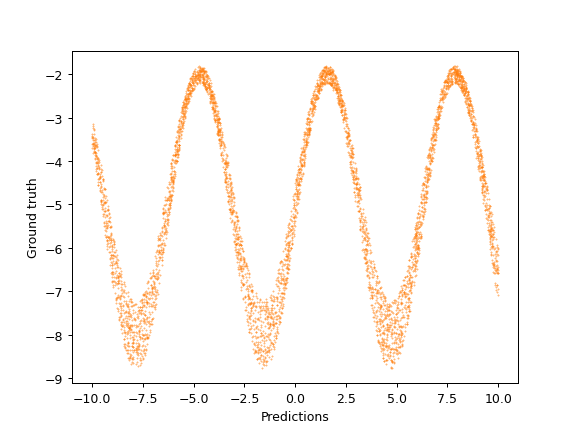

ValueError: m has more than 2 dimensions

In [9]:
prediction = res.predict(test_feat)
show_correlation(prediction, test_ranking)

## 3. Nonlinear regression using a simple perceptron and a simple ANN.

### Let’s try to fit to a simple sine function y = 3 sin(x) + 5 with the simple perceptron and a simple fully connected network. 

#### a) Use the generate_data() function provided in the reference file to generate the training data (5000 points). Do 5-fold cross validation with the simple perceptron model. How well is the prediction? Generate 1000 new points as your test data, and use the show_correlation() function to see how well your model agree with the test data

In [10]:
def generate_X(number):
    xs=(np.random.random(number)*2-1)*10
    return xs
    
def generate_data(number,stochascity=0.05):
    xs=generate_X(number)
    fs=3*np.sin(xs)-5
    stochastic_ratio=(np.random.random(number)*2-1)*stochascity+1
    return xs,fs*stochastic_ratio

In [11]:
x,y=generate_data(5000,0.1)
x = x.reshape(-1,1)
y = y.reshape(-1,1)
plt.scatter(x,y,s=0.1)

In [13]:
## Test using the simple perceptron of 5 fold cross validation 
train_feat,test_feat,train_ranking,test_ranking=skl_model.train_test_split(x, y, test_size = 0.20)
res = Kfold(k=5, Xs=x, ys=y, epochs=1000)

Number of epochs with lowest validation: 1
Train error: 18.031315267279012
Test error: 17.361672473814814
Number of epochs with lowest validation: 2
Train error: 11.762230215394784
Test error: 11.27349453464254
Number of epochs with lowest validation: 3
Train error: 8.332592975160216
Test error: 7.954416562989781
Number of epochs with lowest validation: 4
Train error: 6.455223465887265
Test error: 6.154172904577457
Number of epochs with lowest validation: 5
Train error: 5.442974619149338
Test error: 5.186405412889929
Number of epochs with lowest validation: 6
Train error: 4.874303072812014
Test error: 4.678205935720518
Number of epochs with lowest validation: 7
Train error: 4.599622383578029
Test error: 4.460448966077511
Number of epochs with lowest validation: 8
Train error: 4.404149815126484
Test error: 4.267190310486488
Number of epochs with lowest validation: 9
Train error: 4.320978099766826
Test error: 4.198570049991432
Number of epochs with lowest validation: 10
Train error: 4.26

Number of epochs with lowest validation: 15
Train error: 4.234263093048337
Test error: 4.188971156995241
Number of epochs with lowest validation: 15
Train error: 4.21681262440064
Test error: 4.1520781638795725
Number of epochs with lowest validation: 15
Train error: 4.217172173870396
Test error: 4.167622094012851
Number of epochs with lowest validation: 15
Train error: 4.218990674925963
Test error: 4.153172580613375
Number of epochs with lowest validation: 15
Train error: 4.216028999919892
Test error: 4.151287391897138
Number of epochs with lowest validation: 15
Train error: 4.244896325485638
Test error: 4.201299803643993
Number of epochs with lowest validation: 15
Train error: 4.215872256326835
Test error: 4.151163247581411
Number of epochs with lowest validation: 15
Train error: 4.2112111941588815
Test error: 4.1492445412942205
Number of epochs with lowest validation: 15
Train error: 4.2160144518866165
Test error: 4.151255065537074
Number of epochs with lowest validation: 15
Train er

Number of epochs with lowest validation: 15
Train error: 4.219380010872839
Test error: 4.152935119005822
Number of epochs with lowest validation: 15
Train error: 4.2352507708686895
Test error: 4.1633996786277
Number of epochs with lowest validation: 15
Train error: 4.210389870718718
Test error: 4.157084933361228
Number of epochs with lowest validation: 15
Train error: 4.228208539745871
Test error: 4.15881368470295
Number of epochs with lowest validation: 15
Train error: 4.2091616341977165
Test error: 4.154711598165059
Number of epochs with lowest validation: 15
Train error: 4.223849426937684
Test error: 4.155942251208864
Number of epochs with lowest validation: 15
Train error: 4.208244752169612
Test error: 4.1496278671942175
Number of epochs with lowest validation: 15
Train error: 4.21994776309224
Test error: 4.153389047771575
Number of epochs with lowest validation: 15
Train error: 4.2079623679983795
Test error: 4.150115327632982
Number of epochs with lowest validation: 15
Train error

Train error: 4.208121215028386
Test error: 4.152069180899434
Number of epochs with lowest validation: 15
Train error: 4.210820060495084
Test error: 4.158055030051326
Number of epochs with lowest validation: 15
Train error: 4.208002260349345
Test error: 4.150296597812858
Number of epochs with lowest validation: 15
Train error: 4.208756848063112
Test error: 4.149235388422755
Number of epochs with lowest validation: 15
Train error: 4.207938561753213
Test error: 4.150148449999245
Number of epochs with lowest validation: 15
Train error: 4.21964529400704
Test error: 4.170373442533106
Number of epochs with lowest validation: 15
Train error: 4.20876477486106
Test error: 4.153775824347991
Number of epochs with lowest validation: 15
Train error: 4.2129835694521445
Test error: 4.160978074219337
Number of epochs with lowest validation: 15
Train error: 4.207894542070848
Test error: 4.149569570835411
Number of epochs with lowest validation: 15
Train error: 4.207928645367188
Test error: 4.15109579186

Number of epochs with lowest validation: 15
Train error: 4.212913966402306
Test error: 4.149759747620503
Number of epochs with lowest validation: 15
Train error: 4.217198426570818
Test error: 4.151729756089242
Number of epochs with lowest validation: 15
Train error: 4.208055402184508
Test error: 4.151758492723993
Number of epochs with lowest validation: 15
Train error: 4.2123260605897395
Test error: 4.149390598849166
Number of epochs with lowest validation: 15
Train error: 4.211019038317387
Test error: 4.149053316952855
Number of epochs with lowest validation: 15
Train error: 4.20798049613181
Test error: 4.151425115167181
Number of epochs with lowest validation: 15
Train error: 4.21610709741116
Test error: 4.151343334262607
Number of epochs with lowest validation: 15
Train error: 4.208178048599148
Test error: 4.149684461010871
Number of epochs with lowest validation: 15
Train error: 4.208020328374288
Test error: 4.15007651816397
Number of epochs with lowest validation: 15
Train error: 

Number of epochs with lowest validation: 15
Train error: 4.210163156188911
Test error: 4.148914791012623
Number of epochs with lowest validation: 15
Train error: 4.208966464199893
Test error: 4.154215169565503
Number of epochs with lowest validation: 15
Train error: 4.20874224839309
Test error: 4.153761839362928
Number of epochs with lowest validation: 15
Train error: 4.207965114245495
Test error: 4.151335381372373
Number of epochs with lowest validation: 15
Train error: 4.2087888666407
Test error: 4.153963888112086
Number of epochs with lowest validation: 15
Train error: 4.2350710261737
Test error: 4.163483375361957
Number of epochs with lowest validation: 15
Train error: 4.208615452566904
Test error: 4.153522034167659
Number of epochs with lowest validation: 15
Train error: 4.2089452619178145
Test error: 4.149039047060176
Number of epochs with lowest validation: 15
Train error: 4.209772642891116
Test error: 4.148863720335277
Number of epochs with lowest validation: 15
Train error: 4.

Number of epochs with lowest validation: 15
Train error: 4.221068204787111
Test error: 4.154198152117171
Number of epochs with lowest validation: 15
Train error: 4.21023770494189
Test error: 4.148968423580315
Number of epochs with lowest validation: 15
Train error: 4.216007353158793
Test error: 4.151443107329825
Number of epochs with lowest validation: 15
Train error: 4.220051449252885
Test error: 4.153559563146084
Number of epochs with lowest validation: 15
Train error: 4.2182204431473265
Test error: 4.168481343997284
Number of epochs with lowest validation: 15
Train error: 4.2145153741674175
Test error: 4.150461389083317
Number of epochs with lowest validation: 15
Train error: 4.2096441092784715
Test error: 4.1488200489405305
Number of epochs with lowest validation: 15
Train error: 4.216491083891946
Test error: 4.151512080095965
Number of epochs with lowest validation: 15
Train error: 4.227354542762336
Test error: 4.158193641544495
Number of epochs with lowest validation: 15
Train er

Number of epochs with lowest validation: 15
Train error: 4.2079517332573495
Test error: 4.151210501589099
Number of epochs with lowest validation: 15
Train error: 4.207867702259013
Test error: 4.15007164702021
Number of epochs with lowest validation: 15
Train error: 4.208198428023755
Test error: 4.152235653886665
Number of epochs with lowest validation: 15
Train error: 4.209811268015451
Test error: 4.148786934857387
Number of epochs with lowest validation: 15
Train error: 4.208495685837095
Test error: 4.148898215887975
Number of epochs with lowest validation: 15
Train error: 4.219955392559579
Test error: 4.153134043205849
Number of epochs with lowest validation: 15
Train error: 4.208476864738288
Test error: 4.152836376080337
Number of epochs with lowest validation: 15
Train error: 4.220494528974045
Test error: 4.153689165377661
Number of epochs with lowest validation: 15
Train error: 4.215669208909441
Test error: 4.151019240413476
Number of epochs with lowest validation: 15
Train error

Number of epochs with lowest validation: 15
Train error: 4.208464815857842
Test error: 4.15304800484843
Number of epochs with lowest validation: 15
Train error: 4.208109258331927
Test error: 4.151885294176656
Number of epochs with lowest validation: 15
Train error: 4.210463496457283
Test error: 4.148804522558952
Number of epochs with lowest validation: 15
Train error: 4.225828244837161
Test error: 4.156930365494078
Number of epochs with lowest validation: 15
Train error: 4.214016948505372
Test error: 4.150111122367708
Number of epochs with lowest validation: 15
Train error: 4.225978417135258
Test error: 4.157004652017975
Number of epochs with lowest validation: 15
Train error: 4.210764608886171
Test error: 4.14890804683944
Number of epochs with lowest validation: 15
Train error: 4.207892253937707
Test error: 4.15003009319428
Number of epochs with lowest validation: 15
Train error: 4.22011610892216
Test error: 4.153592632697156
Number of epochs with lowest validation: 15
Train error: 4.

Number of epochs with lowest validation: 15
Train error: 4.256656908644353
Test error: 4.179763045132317
Number of epochs with lowest validation: 15
Train error: 4.208023541867444
Test error: 4.150880734686274
Number of epochs with lowest validation: 15
Train error: 4.209187489026139
Test error: 4.155047492354184
Number of epochs with lowest validation: 15
Train error: 4.210384649578722
Test error: 4.157193748295895
Number of epochs with lowest validation: 15
Train error: 4.2125982841069405
Test error: 4.1502283668065925
Number of epochs with lowest validation: 15
Train error: 4.208060307169699
Test error: 4.150531033288793
Number of epochs with lowest validation: 15
Train error: 4.208028409362748
Test error: 4.151708991647007
Number of epochs with lowest validation: 15
Train error: 4.2080709577343764
Test error: 4.151943788078952
Number of epochs with lowest validation: 15
Train error: 4.211199962798229
Test error: 4.149771338316983
Number of epochs with lowest validation: 15
Train er

Number of epochs with lowest validation: 15
Train error: 4.208134777534911
Test error: 4.151922119752484
Number of epochs with lowest validation: 15
Train error: 4.214286983169121
Test error: 4.1500810603946015
Number of epochs with lowest validation: 15
Train error: 4.2469768429917805
Test error: 4.171887995329097
Number of epochs with lowest validation: 15
Train error: 4.218429632933985
Test error: 4.152180365334814
Number of epochs with lowest validation: 15
Train error: 4.208324157861258
Test error: 4.149074508255312
Number of epochs with lowest validation: 15
Train error: 4.20871228466172
Test error: 4.148889168516304
Number of epochs with lowest validation: 15
Train error: 4.2083088750094735
Test error: 4.1494518710639765
Number of epochs with lowest validation: 15
Train error: 4.217675393301835
Test error: 4.151694518768862
Number of epochs with lowest validation: 15
Train error: 4.208284444513657
Test error: 4.1525861613221675
Number of epochs with lowest validation: 15
Train e

Number of epochs with lowest validation: 15
Train error: 4.219493737082387
Test error: 4.153281643972006
Number of epochs with lowest validation: 15
Train error: 4.2255194288061215
Test error: 4.157185300341598
Number of epochs with lowest validation: 15
Train error: 4.216752172611105
Test error: 4.151502609166963
Number of epochs with lowest validation: 15
Train error: 4.214537930615237
Test error: 4.163316762367749
Number of epochs with lowest validation: 15
Train error: 4.212349106223138
Test error: 4.149371034719403
Number of epochs with lowest validation: 15
Train error: 4.216668801690497
Test error: 4.151585257123147
Number of epochs with lowest validation: 15
Train error: 4.208709190297904
Test error: 4.149430364767389
Number of epochs with lowest validation: 15
Train error: 4.220242503433436
Test error: 4.153946335576749
Number of epochs with lowest validation: 15
Train error: 4.208023144103413
Test error: 4.151680584426058
Number of epochs with lowest validation: 15
Train erro

In [14]:
## Generate another 1000 points 
x_new, y_new = generate_data(1000)
prediction = res.predict(x_new)

<IPython.core.display.Javascript object>


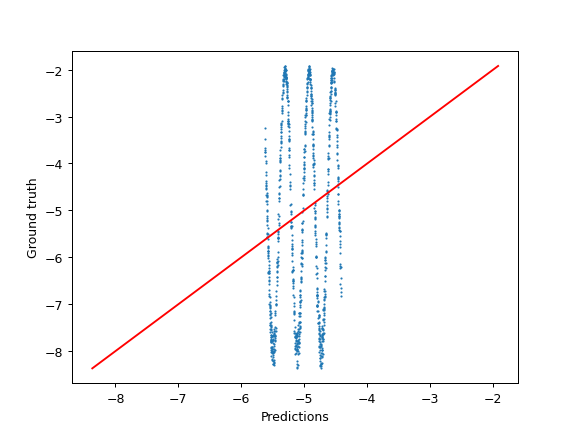

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 1000) + inhomogeneous part.

In [15]:
## use show_correlation() function 
show_correlation(prediction, y_new)

#### Not a good predictor 

#### b) Use the multilayer perceptron regressor of scikit-learn as a simple fully connected neural network. Use one hidden layer with 8 neurons. Do 5-fold cross validation with this simple ANN, and report the MSE on each fold. Visualize the correlation of your model prediction and the true test data.  Is the result better than a simple perceptron?

In [16]:
### Use mlp regressor to fit the data
from sklearn.neural_network import MLPRegressor

def KFold_NN(k,Xs,ys,hidden_layers,epochs=1000,lr=0.001,):
    # The total number of examples for training the network
    total_num=len(Xs)

    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    train_error_all=[]
    test_error_all=[]
    for train_selector,test_selector in kf.split(range(total_num)):
        # Decide training examples and testing examples for this fold
        train_Xs=Xs[train_selector]
        test_Xs=Xs[test_selector]
        train_ys=ys[train_selector]
        test_ys=ys[test_selector]
        
        # Establish the model here
        model = MLPRegressor(max_iter=epochs, activation='tanh', early_stopping=True, 
                             validation_fraction=0.25, learning_rate='constant', learning_rate_init=lr,
                             hidden_layer_sizes=hidden_layers).fit(train_Xs, train_ys)
        
        ### Report result for this fold ##
        train_error=model.score(train_Xs,train_ys)
        train_error_all.append(train_error)
        test_error=model.score(test_Xs,test_ys)
        test_error_all.append(test_error)
        print("Train error:",train_error)
        print("Test error:",test_error)

    print("Final results:")
    print("Training error:%f+-%f"%(np.average(train_error_all),np.std(train_error_all)))
    print("Testing error:%f+-%f"%(np.average(test_error_all),np.std(test_error_all)))
    
    # return the last model
    return model

In [17]:
### Use KFold_NN to fit the data
model=KFold_NN(5,x,y,(8,),epochs=1000,lr=0.001)

/home/jeffy011/CHEM277B/msse/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train error: 0.0435358567266958
Test error: 0.04163954797199387


/home/jeffy011/CHEM277B/msse/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jeffy011/CHEM277B/msse/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jeffy011/CHEM277B/msse/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train error: 0.8276814619373554
Test error: 0.8207449285740198


/home/jeffy011/CHEM277B/msse/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jeffy011/CHEM277B/msse/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train error: 0.8665995878794692
Test error: 0.8530059389986093
Train error: 0.05748022634030936
Test error: 0.05200017105485166


/home/jeffy011/CHEM277B/msse/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train error: 0.043141038732242176
Test error: 0.04378075863224018
Final results:
Training error:0.367688+-0.391699
Testing error:0.362234+-0.387693


In [21]:
show_correlation(np.reshape(model.predict(x_new), (1000,)), y_new)

ValueError: Expected 2D array, got 1D array instead:
array=[ 3.84673463  8.37536705  7.11324542  8.46447449 -0.20856627 -9.40836821
 -7.20557837 -7.42632898  1.38284956 -6.04773982  5.35383428  4.66633475
 -8.09365148  1.36129627 -0.33996688  1.88313444 -6.5901839  -2.36167318
  1.28471425  8.07025176  8.089155   -0.31035479  9.5185888   7.18206898
  6.65533667  4.77501727  1.22594775 -7.00161214  4.64874603  9.75488964
 -5.7669816   0.67066247  6.88643608  9.03014113 -3.25238107 -8.37095126
 -9.96057019  8.29710902 -2.99758672 -2.44134059 -8.83917628 -5.9447495
  2.59020388 -0.13019584  6.13670092 -9.58339231 -1.40552993 -3.64613068
 -6.32540761  8.72049456 -5.07104542 -3.1675804   0.5152003  -2.33489781
  0.11971233  1.53065807  0.07791342  8.83113261 -3.21682018  8.49669075
  1.71987053  5.6074479   6.52865091  0.24573863  7.54310907 -2.13619419
  0.93051473 -1.48870771 -5.71856517  7.44329552 -7.74825416 -5.71395721
  0.90331602 -0.48524556 -6.99545106  0.50736413 -3.18312457 -7.70438366
  5.41585895 -7.51238951 -2.50972337  0.23382624  3.41891548  2.62159699
  7.23010822  4.99287885 -6.6426652  -3.3810864  -7.85099058 -1.07933178
  7.30179731  8.23737218  6.73752851 -1.31377585 -8.43387861  9.55779429
  5.37119668 -6.82630565  1.45393388 -4.03844826 -3.52109104 -7.41149648
 -0.13649565  6.17996822 -5.87595753  7.3686588  -9.81756115  7.98419497
  8.01603879  9.69540826 -6.12554562  5.94967175  5.85930721  7.80509295
  9.84335006  6.67853416  8.22442418 -8.22899224 -2.12351447  1.41477626
  9.56410674  3.12357366  3.28784423  4.07816793 -0.75975993  6.28708661
  5.42061722 -9.17208834 -5.08685317  2.44862583  8.78412284  1.17583601
  3.22543669  2.69061183 -8.14515796 -0.33698527  9.22861513  0.24753209
  8.12017435  3.37616705 -7.88460392  5.78250062 -1.33644199 -9.00816657
 -0.77526526  5.55383613 -9.75015635  0.04501448  5.14169711  8.63797171
  2.00192632 -4.80987559  9.57060532 -0.44162394  6.64811824  9.14100033
 -5.71005854  1.27542275 -0.1072897   0.56501288 -4.88283644 -0.45390668
 -7.56774266 -8.87228864 -8.77428885  6.51818369 -9.42394382  5.91715091
 -4.29561097 -0.80915621  1.96479055  6.45242405  1.29082098  9.75609173
 -6.05269138  9.39111132  7.49694773  9.7684191  -5.51502184 -4.97703238
 -0.70301183 -7.83383101 -6.65725858  2.68573366 -7.08569502  5.63550022
 -6.97316205 -9.65000649  2.76187065 -7.13567479 -6.36344998  3.68871397
  7.86057608 -9.74572676 -6.50611031  6.93928765  5.88214627  4.90072776
  3.19539243 -3.12265488  1.99607628  8.4798125  -9.68352959 -4.70667927
  4.73990426  1.01307985 -4.49301826  8.12661868 -7.76488569 -0.02613812
 -2.84681252  6.97918233 -5.65119048 -9.82533292  3.58632034 -3.94217634
 -6.67204407  3.85357623  9.57853899 -4.31855178  4.90122167 -9.46252425
 -4.01619152 -2.62822507  6.81401813 -7.08493184  0.73109839 -7.39756358
  0.33051295 -2.27611957 -1.47219355  4.53902245 -4.8999472   3.47801233
 -9.24372426  0.09028886  4.56991378 -4.03229156  5.21127435 -4.8126472
 -3.63395259 -7.53823572 -1.24379928 -0.01934089  0.37811744  4.2036226
  1.98189943 -6.11501848 -9.60546514  8.66835525 -9.57562358 -3.03492559
 -2.26508265  1.21143933 -4.07802574 -3.79653401  8.20712806 -2.21079566
  3.64172     1.40713247  2.17150635 -8.03725472 -2.91344471  9.25557893
 -6.90767784 -5.800169   -0.57443135 -0.95381558  0.72977979  8.47177595
 -6.59135375 -4.93598757  7.07475366 -2.34485003 -9.05799313  5.08071908
  7.54506864 -5.76780598  2.10368854 -5.61382712 -6.67793927 -3.48142062
  5.41049033 -6.94684508 -0.91810321  8.11441439 -4.52575368 -0.52107863
 -7.32096278  7.96068202  3.39359414  3.32705552  9.17475761 -0.64260972
 -7.93005457  9.5849064   6.7850448   5.37862094  9.91099177 -7.58793958
 -8.33320685 -8.88223395 -5.19685009 -9.69615637  0.79831283 -5.44956393
  1.12559578 -7.95080166  6.08799507 -5.90985534  2.99891444 -1.43014547
 -1.09552615 -0.74194077 -8.63533743  6.95785548 -4.19674402 -2.20921816
 -2.93686277  2.54678947 -8.10495754 -4.37781848 -2.96275872 -5.21412262
 -6.09088201  6.79584772 -2.94698696 -1.85338267  1.41425627 -3.63687591
  9.64835519  6.14067046 -2.28893341  3.94325507  1.12975115  2.65129565
  4.68961632  4.22537031 -1.63764843 -9.07379323 -8.04396833 -4.47033452
 -2.5923671  -4.39592987 -5.48859356  9.12083646 -9.24533208  5.80580894
 -4.64581873 -5.28193927  8.17405488 -2.2969025  -4.95074234 -7.15539724
 -6.67851654  3.5950985   0.07297595  8.47046836 -1.90186926  4.97836387
  3.58546928  1.32533812 -1.97506459 -1.92210032  5.45913764 -5.13049611
  7.53879811  2.32211848  5.67985452 -1.53521138  0.41061117 -9.77265493
 -7.0447003  -6.16234868  3.0973466  -0.4526862   7.96464664  4.5043601
 -5.5042725   8.41800323 -4.25028721 -4.06121006 -3.072998    7.91577349
 -1.04155996  2.42752562 -0.55757358 -9.33119014 -9.83714446  7.18776532
 -0.44452389  0.34916695 -9.73076048 -5.03761173  3.8739704  -3.6149243
  0.65769458 -1.84068     6.37095211  5.78067239 -8.73159189 -8.86012361
  8.82754943 -5.72431083 -7.35708933 -4.84535158 -6.42651875  2.70115552
  7.60709072 -5.04390056 -6.74458984  1.46494135 -6.04535766  1.91312889
  6.31700404 -6.64132445  6.22568639  9.46474269 -2.56601014 -8.51813245
 -0.0719961   5.44948793  1.73525245 -9.27909601 -8.50497097  0.15839876
  1.87114901  1.69568099 -5.34669124  8.05056533  3.78324764 -5.60766728
 -6.03510559 -4.13390464  5.84966302 -4.31752794 -7.550888    3.35886082
  9.90016028  9.06495045 -7.51228585 -8.54305626 -9.42894238 -8.28899358
  2.96157774  6.59074292  4.42261501 -0.10910689 -9.68264597 -5.0982386
  3.50163703 -7.31034995 -5.5343102   1.45867428  7.48866966  4.20216413
  6.37958397  7.24766272  1.32117851 -8.08230589 -8.0050628  -2.76882997
 -4.48825813 -9.71779374 -8.52869282 -2.53822456 -0.27866655  1.20758626
 -7.37488498 -6.11049752 -1.79964619  8.4942979   9.98237965  4.40576781
 -1.91564139 -9.09908248  8.46674789  9.47493407 -3.87802848 -9.75825653
  2.49364281 -3.34135662  4.72499967  0.81091788  5.54125454 -7.03851161
 -8.25650928 -6.87276445  9.67573469  9.73654672 -0.80541982  8.64610999
  3.80091079  5.42097705  6.92061871  1.95380565 -8.70677491 -4.65734404
  5.76751579 -6.27802252 -4.08877957  4.78847704 -4.24280547 -1.79314673
 -4.47545491  8.31521984  1.25364396 -4.23294899  9.16903264  4.50913181
 -1.58463859  7.09701753 -0.65198949  9.81180376 -4.2103963  -5.4266918
  9.06244347 -3.09833457 -0.45158921 -9.89148584 -6.55753884 -1.69538513
  2.60300728 -3.8819639  -3.16078056  5.83810682 -2.54034741  0.13988742
 -6.16553213  9.73346894 -6.40689325  6.3122784  -2.33805035 -7.48672519
 -0.56516193  5.46437422 -8.02826045 -8.22762958  0.7536269  -8.34927042
 -7.98700303 -4.93917437  5.72984777  9.36532906 -6.1959412   7.75210287
 -7.16791095 -0.90075178  6.64569144  5.62525205 -6.41393866  6.31985986
 -3.53112187 -3.86112787  6.78677519  3.65494233 -0.8812981   0.84044481
 -9.5134113   8.11885722 -0.64724403 -9.23080703 -0.96478688  2.65530127
 -5.34155137 -7.71965412 -0.41172257 -4.75046194  0.06799764 -3.92246812
  1.57360153  0.99345352 -7.29063528 -9.23581078  8.74910624  0.56223101
 -7.95536061  7.50497008  5.88167584 -6.92802043  7.66806689 -3.07966135
  7.5294414  -0.59475074  4.67487559 -5.94926795  4.07577599 -6.11384017
 -8.22311395 -6.41166352  4.35248288 -4.65315453 -3.83420267  1.86079263
  8.36945027  8.12680222  9.05843031 -8.59019123  5.4995576   1.60356281
 -5.07499638  8.6187052   1.79399785 -1.3281934   5.86373965 -5.00985476
 -8.49446476  7.68433126 -2.76173428  9.88734616  9.88700418 -7.11851595
 -0.29228013  5.43784958 -6.37888602 -6.17236392  6.57258886  8.94557394
 -2.08990025 -9.45474736  8.5392295   7.09643365 -0.41243222  5.08806664
 -1.82182884 -8.15067942  3.83561326 -9.38418989  2.75655846 -8.68848009
  0.49955302  3.915768   -6.98809561 -2.51439294  8.92763573 -6.113314
 -7.65674852 -8.88832866 -7.08570134  9.12503716  8.31197622  6.28727356
 -9.07987842 -9.95197492 -3.65107079 -0.34353719  6.38294485 -4.01677046
  7.43630691  5.52719869  1.25525647 -5.7748726   1.12721575 -5.5502556
 -3.36189924  2.0261633  -9.54459651  8.23152057  1.90328697  0.2489683
  3.93456857 -0.59397975  1.91633821 -0.98527507  0.08628928  9.48653233
 -4.57497253 -8.59205167  1.20872455 -2.47362488 -6.74860875 -5.09674754
  0.84619598  7.15861961  9.09248522 -2.83631659  3.60370804  5.10855066
 -6.91298765  9.10074539 -3.50829809  0.90412104 -7.07415764 -7.8423779
 -8.54962859 -3.89915091 -1.92712642  4.70472278 -4.9268292  -0.89534499
  0.71151209 -5.22852805  6.39305866  1.16617092  2.93821264 -8.78897771
  1.11435991 -9.02856128 -8.1609128   4.22651094  6.2429865   2.96692815
 -2.00516385 -6.16992943 -6.42316417  1.60835678 -3.13319258 -7.74094537
  8.65105318  3.4572355  -2.68069069  4.14153783  6.90768325  9.33437317
  5.83630536 -8.46422975 -5.69874339  0.97954335  0.88817743  8.18195223
  1.1471654  -2.73884906  1.99600781  4.40187514  3.20425346 -8.08228641
 -5.55303567 -7.24180838 -7.20711425  6.44698767  5.40516213  9.35008784
  8.8413062  -2.80131419 -0.39303735  8.77668499  8.5365792  -2.221128
 -4.69369815  0.34167027 -1.94131956 -7.88698834 -2.88774238 -0.53921817
  8.85589728  0.74642742  3.38161766  5.86019583  6.55182305  4.4052254
 -1.14740734 -2.80094896 -3.32798182  9.65090877 -9.84003385 -8.46342469
  3.81455896  5.6299455   0.50381687 -9.30125757  7.18284834  5.04149306
  2.53330332  9.02404641 -1.90111617  4.31091461 -4.08397812 -3.30648666
 -0.84657732 -3.532991    2.26516693  2.9274179  -4.96036927  7.97088452
  9.35188065  7.62060349 -1.05191407  2.30812547  4.1751707   9.49251801
  4.66321312  8.5015755   7.62591768  6.97630256 -5.32359867  6.78308375
 -2.78748155 -3.90608725 -7.45878742  4.46960614 -1.26560903 -1.4443825
  5.6130602  -2.57984464  3.82418511  8.87678012  4.41111324 -1.28733445
 -9.15639681  7.82604    -2.48578851  1.83388079 -5.98727201 -1.80747283
  0.26324304  0.22882881 -1.74188586 -9.83780013  8.37858235 -7.08143883
  3.37245549  5.42669558  8.86969772 -5.57613243 -6.94118438  6.80909294
  5.80084836  5.01238471 -9.70735085  3.81736866 -3.11815176 -0.20977136
  7.15050493  1.59822353  4.74705528  7.45665286 -2.91209367 -1.90338255
 -7.13729521 -4.63129805 -3.93491561 -3.93341637  6.58191475 -9.67669374
  7.6453007   0.39517284 -5.12423388  8.62252746  2.90517376  5.78777419
 -7.78493316  0.68366529 -9.98274371  7.23122791 -4.5170199  -7.06332108
 -4.74843143  6.23315558 -5.72587825 -2.57187407  8.49820434  2.45164635
 -2.44456591 -9.84028689  4.72802993  6.38902948  4.17672362 -3.64797286
  2.59430635  3.074938   -6.81787459 -9.93090423  4.68932558 -0.43440459
 -8.94659397  1.90596644 -2.00608649 -4.71104549 -1.15188345 -0.36047576
 -9.2913792   9.32807733 -6.84314761 -6.6009751   2.32076554  3.49187684
 -6.40516765  3.17396937 -2.90609677  1.67007102  4.14739176  1.40101193
  9.56418317  2.61362696 -3.04999754 -7.8136283  -5.48542787  0.17912064
  9.97842283  5.21897461 -3.27567379  5.8527394  -0.83922884 -5.93317085
  3.66786806 -8.59009678  3.14233521 -2.28040402 -9.94374721  6.38373392
 -6.42053793  7.41944885 -7.54651331  4.62650234 -7.50083281 -0.86842687
  9.1808245   1.89432625 -8.7328684  -8.04611809  2.28746886  0.39369729
  0.78598468 -2.60798649  1.08580202  0.52371345 -8.3720526  -8.08747345
 -8.86379599  7.24915957 -4.5911096   3.08719991 -6.08729613  3.77844107
 -6.36701221  6.8037493   7.59593687 -0.28028849 -3.70039231  6.65757327
  3.49431175  3.94300491 -6.05435374  5.513807    2.83650232  4.01987095
 -5.14046961 -7.09081934 -3.15417107 -4.26523192  6.2836147   8.29708248
 -1.37499936 -2.48980669 -9.36316567 -4.95103647 -3.12653052 -8.20001632
 -9.5466116   3.67538621  5.49511564  9.45410486 -7.02230526  9.79126257
 -1.74157527  7.64845353 -3.12191271  9.52029532  1.29643848  1.20502081
  4.74196414 -1.66972351  5.27010488 -7.85943487 -2.45346808 -2.95372037
  3.57621764 -3.66217163 -0.46372154 -3.49875883 -1.33046343  1.92707407
 -4.85845093 -0.78675529  6.26061697  3.48878622 -3.68912001  3.90713699
  7.10820446 -5.0623126   7.93032123 -6.95614218 -6.55181414 -7.42774479
 -9.78160807 -1.55416341 -5.44652296  7.6018306   9.99227366  9.33507002
 -4.22232577 -6.93340486 -0.22006932 -3.39573584  4.48839511  8.56900121
 -3.57517951  6.67691098  1.37159624 -7.46200693].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

#### c) Play with the architecture for the ANN, can you improve the performance by including additional hidden layers?

In [ ]:
### Use KFold_NN to fit the data
model=KFold_NN(5,x,y,(10,10),epochs=1000,lr=0.001)

/home/jeffy011/CHEM277B/msse/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
